In [110]:
!pip install -r requirements.txt

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io
from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
from testCases import *
from public_tests import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


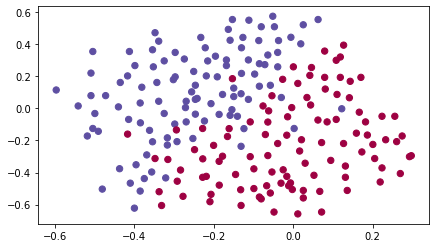

In [112]:
train_X,train_Y,test_X,test_Y = load_2D_dataset()

In [113]:
# Non-regularized model
def model (X,Y,learning_rate = 0.3,num_iterations=30000,print_cost=True,lambd=0,keep_prob=1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0],20,3,1]

    parameters = initialize_parameters(layers_dims)

    for i in range(0,num_iterations):
        if keep_prob == 1:
            a3,cache = forward_propagation(X,parameters)
        elif keep_prob < 1:
            a3,cache = forward_propagation_with_dropout(X,parameters)

        if lambd == 0:
            cost = compute_cost(a3,Y)
        else:
            cost = compute_cost_with_regularization(a3,Y,parameters,lambd)
        
        assert(lambd == 0 or keep_prob == 1)

        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X,Y,cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X,Y,cache,lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X,Y,cache,keep_prob)

        parameters = update_parameters(parameters,grads,learning_rate)

        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
        



Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724213
Cost after iteration 20000: 0.1385164242326018


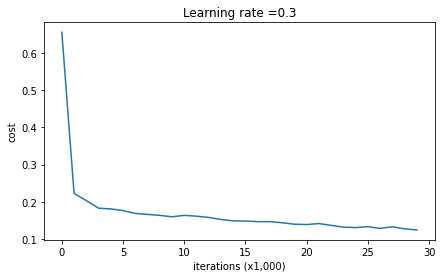

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [114]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

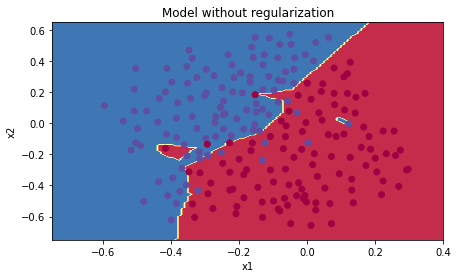

In [115]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y) 

In [116]:
# Forward propagation with L2 regularization
def compute_cost_with_regularization(A3,Y,parameters,lambd):
    m = Y.shape[1]
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    cross_entropy_cost = compute_cost(A3, Y)

    L2_regularization_cost = (1/m)*(lambd/2)*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))

    cost = cross_entropy_cost + L2_regularization_cost

    return cost
    

In [117]:
# Backward propagation with L2 regularization
def backward_propagation_with_regularization(X,Y,cache,lambd):
    m = X.shape[1]
    (Z1,A1,W1,b1,Z2,A2,W2,b2,Z3,A3,W3,b3) = cache

    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3,A2.T) + (lambd/m)*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T,dZ3)
    
    dZ2 = np.multiply(dA2, np.int64(A2>0))

    dW2 = 1./m * np.dot(dZ2,A1.T) + (lambd/m)*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T,dZ2)

    dZ1 = np.multiply(dA1, np.int64(A1>0))

    dW1 = 1./m * np.dot(dZ1,X.T) + (lambd/m)*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients


Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282238
Cost after iteration 20000: 0.26809163371273004


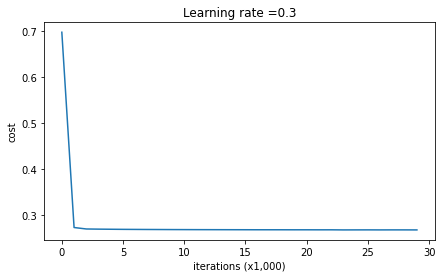

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [118]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

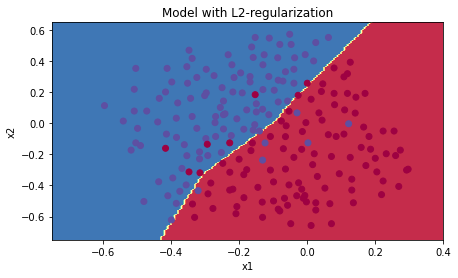

In [119]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

In [120]:
# Forward propagation with dropout regularization
def forward_propagation_with_dropout(X,parameters, keep_prob=0.5):
    np.random.seed(1)

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = np.dot(W1,X) + b1
    A1 = relu(Z1)

    D1 = np.random.rand(A1.shape[0],A1.shape[1])
    D1 = (D1<keep_prob).astype(int)
    A1 = np.multiply(A1,D1)
    A1 = A1/keep_prob

    Z2 = np.dot(W2,A1) + b2
    A2 = relu(Z2)

    D2 = np.random.rand(A2.shape[0],A2.shape[1])
    D2 = (D2<keep_prob).astype(int)
    A2 = np.multiply(A2,D2)
    A2 = A2/keep_prob

    Z3 = np.dot(W3,A2) + b3
    A3 = sigmoid(Z3)

    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)

    return A3,cache

In [121]:
# Backward propagation with dropout regularization
def backward_propagation_with_dropout(X,Y,cache,keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache

    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3,A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T,dZ3)

    dA2 = np.multiply(dA2,D2)
    dA2 = dA2/keep_prob

    dZ2 = np.multiply(dA2,np.int64(A2>0))
    dW2 = 1./m * np.dot(dZ2,A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T,dZ2)

    dA1 = np.multiply(dA1,D1)
    dA1 = dA1/keep_prob

    dZ1 = np.multiply(dA1,np.int64(A1>0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)

    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients
    

Cost after iteration 0: 0.6765787145990387
Cost after iteration 10000: 0.2537893613949999
Cost after iteration 20000: 0.25353125513783775


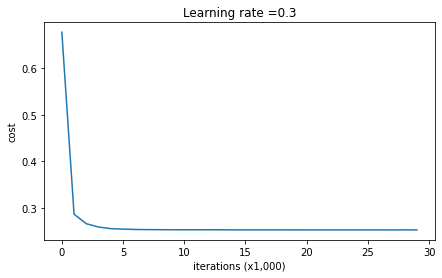

On the train set:
Accuracy: 0.8957345971563981
On the test set:
Accuracy: 0.93


In [122]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

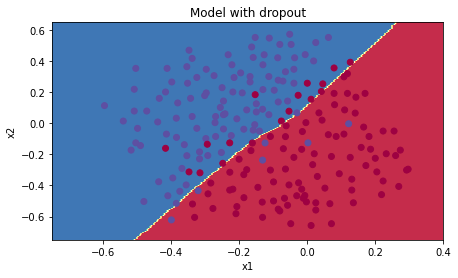

In [123]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)